# Introduction to ML in Practice

In the previous note, we worked through an example of machine learning "by hand," in a very abstract mathematical context. All of the data was given to us as floating point numbers, and there was no messy data preparation to do. This enabled us to go into some detail about what the model was actually doing. We worked with a model with several parameters; generated instances of that model; and saw that selecting the model with the smallest loss led to a good apparent match to the data. 

In practice, the situation is not nearly so neat. There is missing data; some of the data has `NA` values; some of the data is formatted as strings. Furthermore, it's arduous to do all of the steps of the machine learning pipeline by hand, and only machine learning researchers do this on a regular basis. Most programming languages offer simplified interfaces for efficiently working with machine learning models. In this note, we'll work through a similar machine learning pipeline on a more complex historical data set. Along the way, we'll introduce the `scikit-learn` package, which offers an effective and concise set of tools for carrying out complicated machine learning tasks. 

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

To help us get acquainted with the many tools that `scikit-learn` offers us, we are going to work through the "Hello World" of machine learning -- the Titanic data set.

__Before we get started:__ make sure that the file titanic.csv is in the same folder as this notebook

In [28]:
titanic = pd.read_csv("titanic.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


The Titanic data set collects information about almost 900 passangers aboard the Titanic during the fateful voyage when it crashed into an iceberg in 1912 and sank. The information includes their age; the fare they paid for their ticket (in British pounds); their sex; and the passenger class Pclass, with 1st class corresponding to VIP treatment and 3rd class corresponding to a much less luxurious experience. Crucially, the data set also records whether that passenger survived the sinking of the ship, with 1 indicating that the passenger survived and 0 indicating that the passenger tragically perished.

We are eventually going to train an algorithm to predict whether a passenger survived the Titanic based on their available information. Before we do, let's get a sense for some trends using familiar pandas summarization.

How wealthy were these passengers? We can't know for certain, but we can get a sense for how much was paid for each passenger class.



In [29]:
titanic.groupby('Pclass')[['Fare']].aggregate([len, np.mean]).round(2)

/var/folders/jt/m55yxv8d0wxgwy79rkghhwsc0000gn/T/ipykernel_59583/801082116.py:1: FutureWarning: The provided callable <function mean at 0x104ccf2e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  titanic.groupby('Pclass')[['Fare']].aggregate([len, np.mean]).round(2)


Fare       
        len   mean
Pclass            
1       216  84.15
2       184  20.66
3       487  13.71

- The average price of 84 pounds for a first-class ticket corresponds to nearly \$15,000 USD today.
- The second-class ticket corresponds to roughly \$3,500
- The third class ticket corresponds to roughly \$2,500. 

We can safely assume that the first-class passengers were indeed substantially more wealthy on average than the others. 

As we shall see below, this difference in wealth made a considerable difference in how likely passengers were to survive. Moreover, we can also see that sex differences played an import role. 

In [30]:
titanic.groupby(['Pclass',"Sex"])[['Survived']].aggregate([len,np.mean]).round(2)

/var/folders/jt/m55yxv8d0wxgwy79rkghhwsc0000gn/T/ipykernel_59583/3234647397.py:1: FutureWarning: The provided callable <function mean at 0x104ccf2e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  titanic.groupby(['Pclass',"Sex"])[['Survived']].aggregate([len,np.mean]).round(2)


Survived      
                   len  mean
Pclass Sex                  
1      female       94  0.97
       male        122  0.37
2      female       76  0.92
       male        108  0.16
3      female      144  0.50
       male        343  0.14

Wealthy females had a 97% chance of surviving, whereas poor males had a 14%.

This table reflects the famous maritime tradition of prioritizing women and children first into the lifeboats, resulting in vastly higher survival rates among women in these data. Note the role of class: a 1st-class woman was twice as likely to survive as a third class woman, and a 1st-class man was nearly three times as likely to survive as a 3rd class man. 

## Towards Modeling

We'd like to develop automated models that can use these trends and others to make predictions about survival. However, we need to do a bit of data cleaning before we're ready for this. In particular, **machine learning algorithms don't really get text**, so we need to transform text data into numbers before we can proceed. 

To encode the `Sex` data, we use the LabelEncoder function found within the preprocessing submodule of sklearn

In [31]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder() # used to transform text data into numbers before we can proceed

Once we have defined our LabelEncoder, it will do all the hardwork for us

In [32]:
le.fit_transform(titanic["Sex"])

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,

In [33]:
titanic["Sex"] = le.fit_transform(titanic["Sex"])
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,1,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,0,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,0,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,0,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,1,35.0,0,0,8.0500


Let's also drop the name column

In [34]:
titanic = titanic.drop(["Name"], axis = 1)
titanic

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
882,0,2,1,27.0,0,0,13.0000
883,1,1,0,19.0,0,0,30.0000
884,0,3,0,7.0,1,2,23.4500
885,1,1,1,26.0,0,0,30.0000


This looks better! We have a data frame full of sweet, delicious numbers. Mmmmm.....

The next thing to do is to separate out the target data `Survived` from the predictor data (everything else). 

In [35]:
X = titanic.drop(["Survived"], axis = 1)
y = titanic["Survived"]

Now, lets look at X and y

In [36]:
X

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...
882,2,1,27.0,0,0,13.0000
883,1,0,19.0,0,0,30.0000
884,3,0,7.0,1,2,23.4500
885,1,1,26.0,0,0,30.0000


In [37]:
y

0      0
1      1
2      1
3      1
4      0
      ..
882    0
883    1
884    0
885    1
886    0
Name: Survived, Length: 887, dtype: int64

## Modeling

To use a machine learning model from `scikit-learn`, you should import the relevant model. For example, let's use a decision tree classifier. 

In [38]:
from sklearn import tree

In `scikit-learn`, abstract models are represented as classes. To make a specific model, instantiate the class. 

In [39]:
T = tree.DecisionTreeClassifier(max_depth = 2)

Arguments passed to the model upon instantiation are typically used to control how complex the model can be. These arguments are often referred to as *hyperparameters*. In practice, we don't usually know what the *right* hyperparameters are, and so we need to resort to various computational techniques (in coming lectures) to select good ones. 

Now, here's the good news. Once we've carefully prepared our data and instantiated a model, actually fitting the model is unreasonably easy. 

In [40]:
T.fit(X,y)

DecisionTreeClassifier(max_depth=2)

Remember that part in the last note where we defined a loss function and then searched around for models in our specified model family that minimized the loss? Yeah, `scikit-learn` has taken care of all that for us. 

### **`.score(Predictor_Variable, Target_Variable)`**

We can then *score* our model to see how we did in terms of accuracy. The `score` method requires both the predictor and target variables. 

What does the `score` function calculate? It depends by model, but in the case of classifiers, the score is the fraction of the time that the model made the correct prediction. The score does the same job as the <font color="red">loss function</font>, but the signs are flipped -- high scores mean good models. 

In [25]:
T.score(X, y)

0.7914317925591883

Hey, not bad! Our model was able to use the predictor variables to be right nearly 80\% of the time. That's pretty impressive, but there is an important problem here. When doing machine learning, it's not advised to *score* or *evaluate* your model on the same data used for *training* or *fitting* the model. We'll come back to this in the next lecture. 

## Interpretation

In most cases, you should aim to understand how your model makes the decisions that it does. This is the problem of machine learning *interpretation*. 

Every machine learning algorithm has both strengths and weaknesses when it comes to interpretation. Decision trees are pretty pleasant to interpret, as they correspond to "flow-chart" style reasoning that many of us are familiar with. The `tree` module of `scikit-learn` provides a convenient method for visualizing decision trees. 

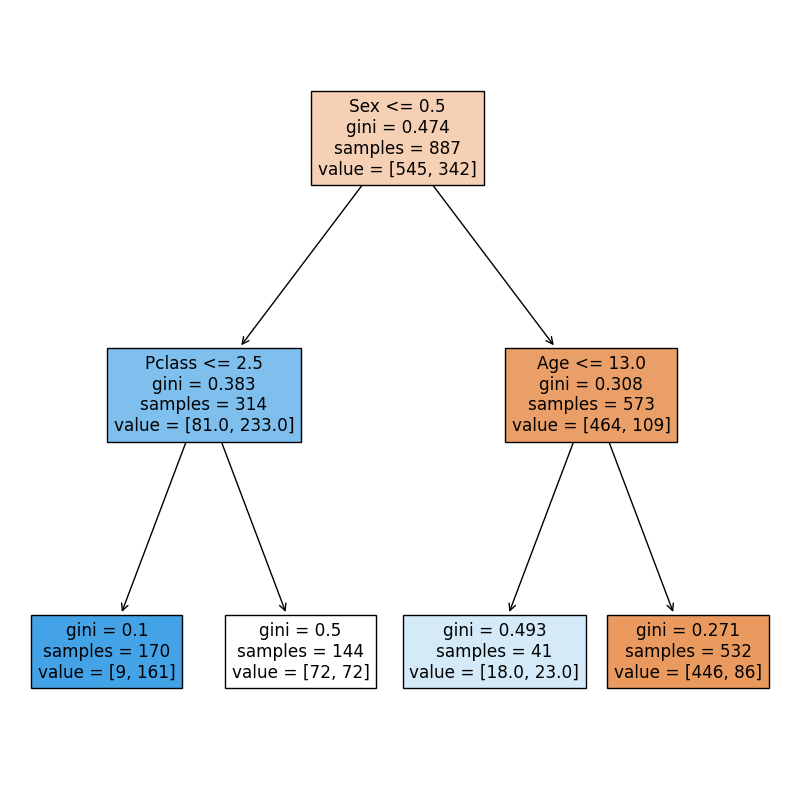

In [16]:
fig, ax = plt.subplots(1, figsize = (10, 10))

p = tree.plot_tree(T,
                   filled=True,
                   feature_names=list(X.columns)
                   )

The automated decision tree classifier has found the following rule to predict whether a passenger survived the Ttianic. First, check whether `Sex <= 0.5` -- that is, check whether the passenger is female. 
- If so, next check whether the passenger was first-class. If so, then they survive with high probability (161/170); otherwise the algorithm isn't sure and gives them a roughly 50-50 chance. 
- If the passenger is male, then check how old they are. If they are younger than 13 years old, the algorithm gives them a fair chance of survival (remember: "women and children."). Otherwise, the algorithm gives them very low odds indeed (86/532). 

We've now gone through one cycle of: 

1. Acquiring data.
2. Exploratory analysis.
3. Modeling. 
4. Interpreting results.

In practice, we would not stop here. Having trained our model, we should then ask: 

- What new insights can we gain from our model about the underlying data set? 
- Can we improve our model?
- How can we use what we have learned in other data sets?

These questions, and many others, are part of the *cycle of data science*: 

<figure class="image" style="width:100%">
  <img src="https://d33wubrfki0l68.cloudfront.net/795c039ba2520455d833b4034befc8cf360a70ba/558a5/diagrams/data-science-explore.png" alt="A diagram with the words import, tidy, transform, visualize, model, and communicate. Import points to tidy. Tidy points to transform. Transform points to visualize, visualize poitns to model, and model points to visualize, thus forming a directed cycle of arrows. This cycle collectively points to the final word, communicate." width="600px">
    <br>
    <caption><i>The cycle of data science. Image credit: Hadley Wickham</i></caption>
</figure>

We've learned to: 

- Import data (`pd.read_csv()`)
- Tidy data (preprocessing)
- Explore data by
    - Transforming (e.g. creating new columns)
    - Visualizing (`matplotlib`)
    - Modeling (basic machine learning)
    
In your project, you'll be expected to go around this cycle multiple times, progressively building up your understanding and *communicating* your results.